In [1]:
from test import create_dataloaders

import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision
from torch.nn.parallel import DataParallel
from torchvision.transforms import ToTensor, Compose, CenterCrop
from matplotlib.lines import Line2D

from utils import Embedding_Dataset, sample_point

target_transform = Compose([
    sample_point,
])
transform = Compose([
    ToTensor()
])
def custom_collate(batch):
    images, targets, embeddings = zip(*batch)
    masks, points = zip(*targets)
    return images, masks, points, embeddings

folder_paths = [
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/EgoHOS/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/GTEA/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/LVIS/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/NDIS Park/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/TrashCan/dataset',
    '/pfs/work7/workspace/scratch/ul_xto11-FSSAM/FSSAM Datasets/ZeroWaste-f/dataset',
]
dataloaders = create_dataloaders(folder_paths, transform=transform, target_transform=target_transform, collate_fn=custom_collate, batch_size=8)

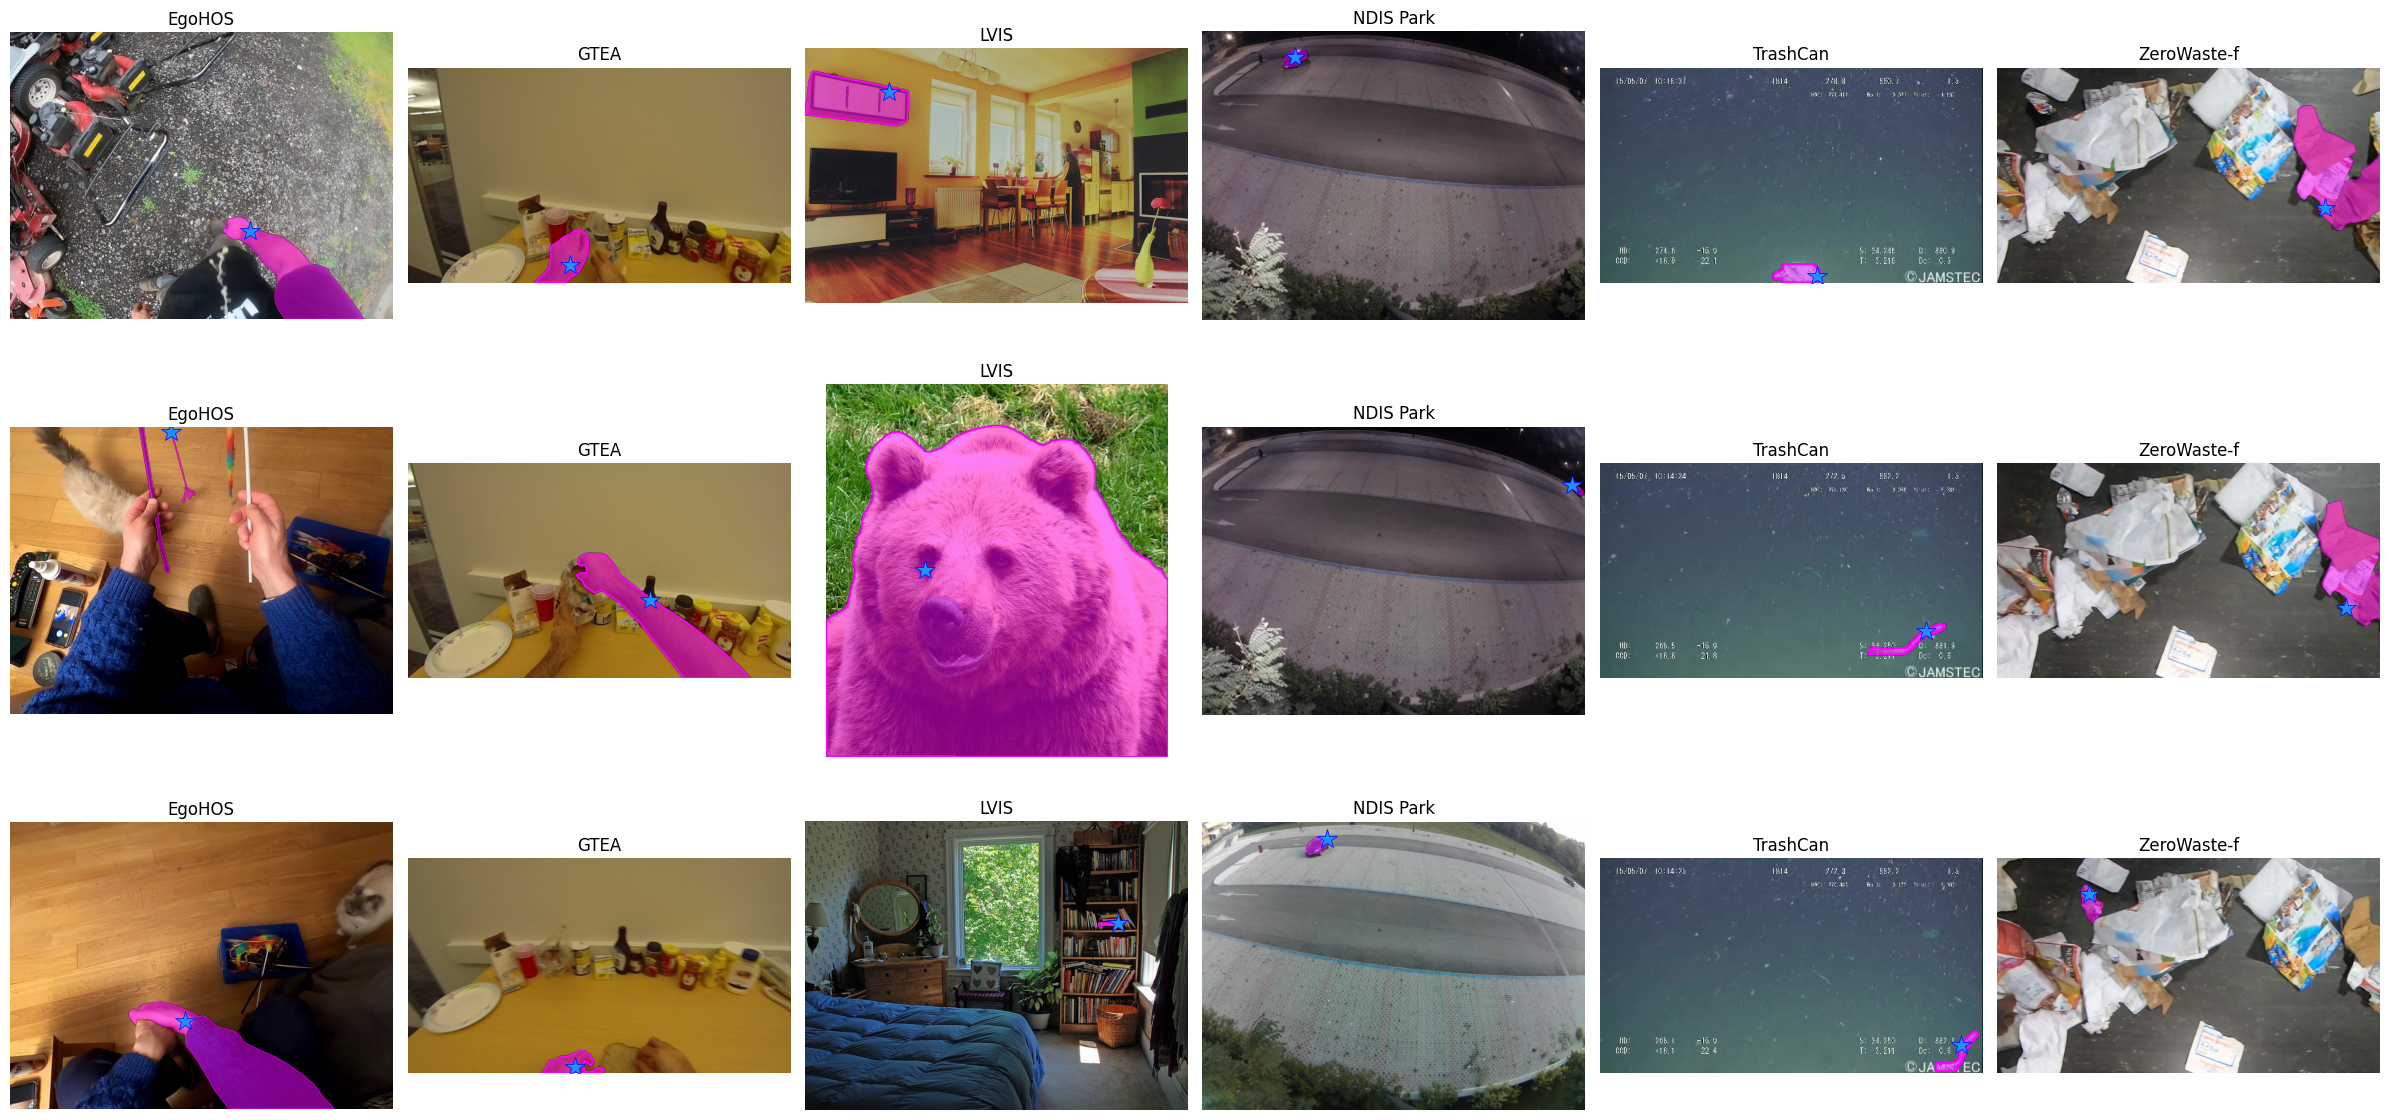

In [14]:
# Calculate the number of rows and columns based on the number of data loaders
num_rows = 3  # Number of images you want to display for each data loader
num_cols = len(dataloaders)  # Number of data loaders

# Create a figure and axis with the calculated layout
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
fig.subplots_adjust(hspace=0.5)

# Plot example images and masks in each cell
for col_idx, (name, data_loader) in enumerate(dataloaders.items()):
    batch = next(iter(data_loader))
    images, masks, points, embeddings = batch  # Assuming you have these variables in the batch
    
    for row_idx in range(num_rows):
        ax = axes[row_idx, col_idx]
        
        # Plot the image
        ax.imshow(images[row_idx].permute(1, 2, 0))
        
        # Draw the mask on top of the image
        col = [255, 0, 255]
        mask_gray = np.asarray(masks[row_idx].permute(1, 2, 0) * 255).astype(np.uint8)
        mask_rgb = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2BGRA)
        mask_rgb[np.where((mask_rgb==[255, 255, 255, 255]).all(axis=2))] = col + [0]
        mask_rgb[:, :, 3] = mask_gray[:, :, 0] * 0.5
        contours, _ = cv2.findContours(mask_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(mask_rgb, contours, -1, col + [255], 2)
        x, y = points[row_idx].numpy().astype(int)
        star_marker = Line2D([x], [y], marker='*', markersize=15, color='dodgerblue', markeredgewidth=0.5, markeredgecolor="blue")
        ax.add_artist(star_marker)
        ax.imshow(mask_rgb)
        
        ax.set_title(name)
        ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()